In [1]:
import sys
sys.path.append('../baselines/text_only/classifier')
import model
# class order = human_damage, fires, damaged_nature, flood, non_damage, damaged_infrastucture

In [2]:
import torch
from torch import nn
from torchtext.data import Field, TabularDataset
from torchtext.data import Iterator, BucketIterator
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import time
import sys
import copy
import sklearn
import sklearn.metrics
import numpy as np
import pickle
import os
from model import Classifier, Encoder, Attention
BASE_PATH = '../baselines'

torch.manual_seed(7)
device = torch.device('cpu')

## Load Resnet Model

In [3]:
resnet_model = torchvision.models.resnet50(pretrained = False)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 6)

resnet_state_file = os.path.join(BASE_PATH, 'img_only', 'output', 'trained_models', 'resnet50_model')
resnet_model.load_state_dict(torch.load(resnet_state_file))
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

Create a new Model that extracts all but the last layer of the resnet

In [4]:
class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        image_modules = list(resnet_model.children())[:-1] #all layer expect last layer
        self.img_model = nn.Sequential(*image_modules)
        
    def forward(self, image):
        a = self.img_model(image)
        x = torch.sigmoid(a)
        return x

In [5]:
x_image = Variable(torch.randn(1, 3, 224, 224))
model = ImageModel()
output = model(x_image)
print(output.shape)
model.eval()

torch.Size([1, 2048, 1, 1])


ImageModel(
  (img_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, 

## Load RNN Model

In [6]:
hyperparams = {
    'rnn_type': 'LSTM', # 'LSTM', 'GRU'
    'embedding_size': 1000,
    'num_hidden_units': 500,
    'num_layers': 2,
    'init_lr': 1e-3,
    'grad_clipping': 5,
    'num_epochs': 10,
    'batch_size': 32,
    'dropout_rate': 0.1,
    'is_bidirectional': True
}
# set up randomly-initialized embedding layer 
embedding = nn.Embedding(48512, hyperparams['embedding_size'], padding_idx = 1, max_norm = 1)
# set up RNN encoder
encoder = Encoder(hyperparams['embedding_size'], 
                  hyperparams['num_hidden_units'], 
                  nlayers = hyperparams['num_layers'], 
                  dropout = hyperparams['dropout_rate'], 
                  bidirectional = hyperparams['is_bidirectional'], 
                  rnn_type = hyperparams['rnn_type'])
# set up self-attention
attention_dim = hyperparams['num_hidden_units'] if not hyperparams['is_bidirectional'] \
                                                else 2 * hyperparams['num_hidden_units']
attention = Attention(attention_dim, attention_dim, attention_dim)
rnn_model = Classifier(embedding, encoder, attention, attention_dim, 6)

rnn_state_file = os.path.join(BASE_PATH, 'text_only', 'output', 'trained_models', 'lstm2_model')
rnn_model.load_state_dict(torch.load(rnn_state_file))
rnn_model.eval()

Total param size: 60534006


Classifier(
  (embedding): Embedding(48512, 1000, padding_idx=1, max_norm=1)
  (encoder): Encoder(
    (rnn): LSTM(1000, 500, num_layers=2, dropout=0.1, bidirectional=True)
  )
  (attention): Attention()
  (decoder): Linear(in_features=1000, out_features=6, bias=True)
)

Create a new Model that extracts all but the last layer of the RNN

In [7]:
class TextModel(nn.Module):
    
    def __init__(self):#, embedding, encoder, attention, hidden_dim, num_classes):
        super(TextModel, self).__init__()
        text_modules = list(rnn_model.children())[:-1] #all layer expect last layer
        self.embedding,self.encoder, self.attention = text_modules 
        
    def forward(self, input):
        outputs, hidden = self.encoder(self.embedding(input))
        if isinstance(hidden, tuple): # LSTM
            hidden = hidden[1] # take the cell state

        if self.encoder.bidirectional: # need to concat the last 2 hidden layers
            hidden = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden = hidden[-1]

        energy, linear_combination = self.attention(hidden, outputs, outputs) 
        return linear_combination

In [8]:
model = TextModel()
model.eval()

TextModel(
  (embedding): Embedding(48512, 1000, padding_idx=1, max_norm=1)
  (encoder): Encoder(
    (rnn): LSTM(1000, 500, num_layers=2, dropout=0.1, bidirectional=True)
  )
  (attention): Attention()
)

## Load Datasets

#### Text Data

In [9]:
intermediates_dir = '../../intermediates'

TRAIN_PATH = 'cleaned_text_train.csv'
VAL_PATH = 'cleaned_text_val.csv'
TEST_PATH = 'cleaned_text_test.csv'

VOCABULARY_PATH = os.path.join(intermediates_dir, 'text_vocabulary.pkl')
vocabulary = pickle.load(open(VOCABULARY_PATH, 'rb'))
num_tokens = len(vocabulary)

tokenize = lambda x: x.split()
TEXT = Field(sequential = True, tokenize = tokenize, lower = True)
LABEL = Field(sequential = False, use_vocab = False)

train_datafields = [('file_name', None), # not needed
                    ('text', TEXT), 
                    ('image_loc', None),
                    ('damaged_infrastructure', LABEL),
                    ('damaged_nature', LABEL),
                    ('fires', LABEL),
                    ('flood', LABEL),
                    ('human_damage', LABEL),
                    ('non_damage', LABEL)]

train, val = TabularDataset.splits(path = intermediates_dir, # the root directory where the data lies
                                   train = TRAIN_PATH, 
                                   validation = VAL_PATH,
                                   format = 'csv',
                                   skip_header = True, 
                                   fields = train_datafields,
                                  )

test = TabularDataset(path = os.path.join(intermediates_dir, TEST_PATH),
                      format = 'csv',
                      skip_header = True,
                      fields = train_datafields)

text_datasets = {
    'train': train,
    'val': val,
    'test': test
}

TEXT.build_vocab(train)

In [10]:
class BatchWrapper:
    def __init__(self, dl, x_var, y_vars, device = device):
        self.dl, self.x_var, self.y_vars = dl, x_var, y_vars # we pass in the list of attributes for x

    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var) # we assume only one input in this wrapper
            if self.y_vars is not None:
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim = 1).float()
            else:
                y = torch.zeros((1))

            yield (x, y)

    def __len__(self):
        return len(self.dl)

In [11]:
# class TextLoader(Dataset):
#     """ Pytorch Dataloader Class for qm9 dataset."""

#     def __init__(self, text_dataset):
#         #  input
#         self.x_data =   # (133885, 2)
#         #  labels
#         self.y_data = X[:,2]  # (133885,)

#     def __getitem__(self, index):

#         return self.x_data[index], self.y_data[index]



In [12]:
text_pickle_files ={
    'train':(os.path.join('deep_embeddings', 'text_train_embeddings_lstm_tuned.pkl'), 
            os.path.join('deep_embeddings', 'text_train_gt_lstm_tuned.pkl')), 
    'val':(os.path.join('deep_embeddings', 'text_val_embeddings_lstm_tuned.pkl'),
          os.path.join('deep_embeddings', 'text_val_gt_lstm_tuned.pkl')),
    'test':(os.path.join('deep_embeddings', 'text_test_embeddings_lstm_tuned.pkl'),
           os.path.join('deep_embeddings', 'text_test_gt_lstm_tuned.pkl'))
}

device = torch.device('cpu')
data_dir = '../../data/text_data'

iteri = iter(range(10000000))

def text_run_handler(model, hyperparams, text_datasets):
    train, val, test = text_datasets['train'], text_datasets['val'], text_datasets['test']
    test_iter = Iterator(test, 
                        batch_size = hyperparams['batch_size'], 
                        device = device,
                        sort = True, 
                        sort_key = lambda x:next(iteri),
                        sort_within_batch = False, 
                        repeat = False)
    test_batcher = BatchWrapper(test_iter, 'text', \
    ['damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage', 'non_damage'], device = device)
    
    train_iter, val_iter = BucketIterator.splits((train, val), 
                            batch_sizes = (hyperparams['batch_size'], hyperparams['batch_size']),
                                            device = device,
                                            sort = True,
                                            sort_key = lambda x:next(iteri),
                                            sort_within_batch = False,
                                            repeat = False)
    train_batcher = BatchWrapper(train_iter, 'text',\
        ['damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage', 'non_damage'], device = device)
    val_batcher = BatchWrapper(val_iter, 'text', \
        ['damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage', 'non_damage'], device = device)

    batchers = {
        'train': train_batcher, 
        'val': val_batcher,
        'test': test_batcher
    }
    
    model.eval()
    with torch.no_grad():
        for split in ['train','val','test']:
            preds_list, gt_list = [], []
            for inputs, labels  in batchers[split]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                preds_list.extend(list(np.asarray(outputs)))
                gt_list.extend(list(np.asarray(torch.max(labels, 1)[1])))

            pickle_fns = text_pickle_files[split]
            with open(pickle_fns[0], 'wb') as handle:
                pickle.dump(preds_list, handle)
            with open(pickle_fns[1], 'wb') as handle:
                pickle.dump(gt_list, handle)

In [13]:
model = TextModel()
#text_run_handler(model, hyperparams, text_datasets)

In [14]:
pickle_off = open(text_pickle_files['train'][0], "rb")
text_deepfeatures_train = pickle.load(pickle_off)
text_deepfeatures_train = np.array(text_deepfeatures_train)
print('Train \n---------------')
print('Shape: '+ str(text_deepfeatures_train.shape))

pickle_off = open(text_pickle_files['val'][0], "rb")
text_deepfeatures_val = pickle.load(pickle_off)
text_deepfeatures_val = np.array(text_deepfeatures_val)
print('\nVal \n---------------')
print('Shape: '+ str(text_deepfeatures_val.shape))


pickle_off = open(text_pickle_files['test'][0], "rb")
text_deepfeatures_test = pickle.load(pickle_off)
text_deepfeatures_test = np.array(text_deepfeatures_test)
print('\nTest \n---------------')
print('Shape: '+ str(text_deepfeatures_test.shape))

Train 
---------------
Shape: (3499, 1000)

Val 
---------------
Shape: (1166, 1000)

Test 
---------------
Shape: (1166, 1000)


#### Image Data

In [15]:
img_pickle_files ={
    'train':(os.path.join('deep_embeddings', 'img_train_embeddings.pkl'), 
            os.path.join('deep_embeddings', 'img_train_gt.pkl')), 
    'val':(os.path.join('deep_embeddings', 'img_val_embeddings.pkl'),
          os.path.join('deep_embeddings', 'img_val_gt.pkl')),
    'test':(os.path.join('deep_embeddings', 'img_test_embeddings.pkl'),
           os.path.join('deep_embeddings', 'img_test_gt.pkl'))
}

device = torch.device('cpu')
data_dir = '../../data/img_data'
transform = transforms.Compose([
        transforms.Resize(size = (224, 224)), # 224 for ResNets, 299 for Inception
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def img_run_handler(model):
    from PIL import ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform) 
                      for x in ['train','val', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 32, shuffle = False, num_workers = 16)
                   for x in ['train','val', 'test']}
    
    model.eval()
    with torch.no_grad():
        for split in ['train','val', 'test']:
            preds_list, gt_list = [], []
            for images, labels in dataloaders[split]:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                # preds_list.extend(list(np.asarray(torch.max(outputs, 1)[1])))
                preds_list.extend(list(np.asarray(outputs)))
                gt_list.extend(list(np.asarray(labels)))
            
            pickle_fns = img_pickle_files[split]
            with open(pickle_fns[0], 'wb') as handle:
                pickle.dump(preds_list, handle)
            with open(pickle_fns[1], 'wb') as handle:
                pickle.dump(gt_list, handle)

In [16]:
model = ImageModel()
#img_run_handler(model)

In [17]:
pickle_off = open(img_pickle_files['train'][0], "rb")
img_deepfeatures_train = pickle.load(pickle_off)
img_deepfeatures_train = np.array(img_deepfeatures_train)
print('Train \n---------------')
print('Shape: '+ str(img_deepfeatures_train.shape))

pickle_off = open(img_pickle_files['val'][0], "rb")
img_deepfeatures_val = pickle.load(pickle_off)
img_deepfeatures_val = np.array(img_deepfeatures_val)
print('\nVal\n---------------')
print('Shape: '+ str(img_deepfeatures_val.shape))

pickle_off = open(img_pickle_files['test'][0], "rb")
img_deepfeatures_test = pickle.load(pickle_off)
img_deepfeatures_test = np.array(img_deepfeatures_test)
print('\nTest \n---------------')
print('Shape: '+ str(img_deepfeatures_test.shape))

img_deepfeatures_train = img_deepfeatures_train.squeeze(axis=(2,3))
img_deepfeatures_val = img_deepfeatures_val.squeeze(axis=(2,3))
img_deepfeatures_test = img_deepfeatures_test.squeeze(axis=(2,3))

Train 
---------------
Shape: (3499, 2048, 1, 1)

Val
---------------
Shape: (1166, 2048, 1, 1)

Test 
---------------
Shape: (1166, 2048, 1, 1)


## Concat Image and Text Deep Features

In [18]:
train = np.concatenate((img_deepfeatures_train, text_deepfeatures_train), axis = 1)
val = np.concatenate((img_deepfeatures_val, text_deepfeatures_val), axis = 1)
test = np.concatenate((img_deepfeatures_test, text_deepfeatures_test), axis = 1)

print(train.shape)
print(val.shape)
print(test.shape)

(3499, 3048)
(1166, 3048)
(1166, 3048)


In [19]:
pickle_off = open(text_pickle_files['train'][1], "rb")
text_train_label = np.array(pickle.load(pickle_off))
pickle_off = open(img_pickle_files['train'][1], "rb")
train_label = np.array(pickle.load(pickle_off))
print(np.sum(np.equal(text_train_label, train_label)))

pickle_off = open(img_pickle_files['val'][1], "rb")
img_val_label = np.array(pickle.load(pickle_off))
pickle_off = open(text_pickle_files['val'][1], "rb")
val_label = np.array(pickle.load(pickle_off))
print(np.sum(np.equal(img_val_label, val_label)))

pickle_off = open(img_pickle_files['test'][1], "rb")
img_test_label = np.array(pickle.load(pickle_off))
pickle_off = open(text_pickle_files['test'][1], "rb")
test_label = np.array(pickle.load(pickle_off))
print(np.sum(np.equal(img_test_label, test_label)))

print(train_label.shape)
print(val_label.shape)
print(test_label.shape)

3499
1166
1166
(3499,)
(1166,)
(1166,)


## Train Feature Fusion

Initialize Linear Layer Model

Create Datasets

In [20]:
train_data = torch.from_numpy(train)
train_labels = torch.from_numpy(train_label)
val_data = torch.from_numpy(val)
val_labels = torch.from_numpy(val_label)
test_data = torch.from_numpy(test)
test_labels = torch.from_numpy(test_label)

ffdatasets = {
    'train': torch.utils.data.TensorDataset(train_data, train_labels),
    'val': torch.utils.data.TensorDataset(val_data, val_labels),
    'test': torch.utils.data.TensorDataset(test_data, test_labels)
}

Define training scheme

In [21]:
def train_model(model, criterion, reg, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs = 25, reg_factor=1e-4):
    # https://github.com/keras-team/keras/issues/5475; to overcome loading errors
    from PIL import ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    finetuning = False
    
    train_loss_history = []
    train_acc_history, val_acc_history = [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
                # train entire network after 5 epochs
                if finetuning == True and epoch >= 5:
                    for param in model.parameters(): 
                        param.requires_grad = True
                    print('Finetuning complete. Training entire network now.')
                    finetuning = False
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #inputs = inputs.unsqueeze(2)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    for param in model.parameters():
                        target = torch.zeros_like(param)
                        loss += reg_factor * reg(param, target)
                    
                    if phase == 'train':
                        train_loss_history.append(loss) # per batch loss
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_acc_history.append(float(epoch_acc.numpy())) # per epoch
            else:
                val_acc_history.append(float(epoch_acc.numpy())) # per epoch
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc, train_loss_history, train_acc_history, val_acc_history

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight) #kaiming_uniform_ xavier_uniform_
        m.bias.data.fill_(0.01)

Define Model

In [23]:
INPUT_DIMS = 3048
HIDDEN_DIMS_1 = 1524
HIDDEN_DIMS_2 = 762
HIDDEN_DIMS_3 = 381
HIDDEN_DIMS_4 = 190
HIDDEN_DIMS_5 = 95
HIDDEN_DIMS_6 = 45
HIDDEN_DIMS_7 = 23
HIDDEN_DIMS_8 = 11
OUTPUT_DIMS = 6

ffmodel = nn.Sequential(
    nn.BatchNorm1d(INPUT_DIMS),
    nn.Linear(INPUT_DIMS, OUTPUT_DIMS),
#     nn.Conv1d(INPUT_DIMS, OUTPUT_DIMS, kernel_size=kernel_size, padding = PADDING, stride = STRIDE),
    
#     nn.ReLU(),
#     nn.Dropout(0.6),
#     nn.BatchNorm1d(HIDDEN_DIMS_1),
#     nn.Linear(HIDDEN_DIMS_1, HIDDEN_DIMS_2),
    
#     nn.ReLU(),
# #     nn.Dropout(0.3),
#     nn.BatchNorm1d(HIDDEN_DIMS_2),
#     nn.Linear(HIDDEN_DIMS_2, HIDDEN_DIMS_3),
    
#     nn.ReLU(),
# #     nn.Dropout(0.3),
#     nn.BatchNorm1d(HIDDEN_DIMS_3),
#     nn.Linear(HIDDEN_DIMS_3, HIDDEN_DIMS_4),
    
#     nn.ReLU(),
# #     nn.Dropout(0.3),
#     nn.BatchNorm1d(HIDDEN_DIMS_4),
#     nn.Linear(HIDDEN_DIMS_4, HIDDEN_DIMS_5),
    
#     nn.ReLU(),
# #     nn.Dropout(0.3),
#     nn.BatchNorm1d(HIDDEN_DIMS_5),
#     nn.Linear(HIDDEN_DIMS_5, HIDDEN_DIMS_6),
    
#     nn.ReLU(),
#     nn.Dropout(0.6),
#     nn.BatchNorm1d(HIDDEN_DIMS_6),
#     nn.Linear(HIDDEN_DIMS_6, HIDDEN_DIMS_7),
    
#     nn.ReLU(),
# #     nn.Dropout(0.3),
#     nn.BatchNorm1d(HIDDEN_DIMS_7),
#     nn.Linear(HIDDEN_DIMS_7, HIDDEN_DIMS_8),
    
#     nn.ReLU(),
# #     nn.Dropout(0.3),
#     nn.BatchNorm1d(HIDDEN_DIMS_8),
#     nn.Linear(HIDDEN_DIMS_8, OUTPUT_DIMS),
)

Create Dataloaders, Optimizer, and Decay Scheduler

In [137]:
dataloaders = {x: torch.utils.data.DataLoader(ffdatasets[x], batch_size = 80, shuffle = True, num_workers = 16)\
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(ffdatasets[x]) for x in ['train', 'val', 'test']}

device = torch.device('cpu')
ffmodel = ffmodel.to(device)
criterion = nn.CrossEntropyLoss()
reg =  nn.MSELoss(reduction='sum')
# observe that only parameters of final layer are being optimized as opposed to before.
optimizer = optim.SGD(ffmodel.parameters(), lr = 0.01, momentum = 0.9)
# optimizer = optim.Adam(ffmodel.parameters(), lr = 0.0009)
# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

In [138]:
ffmodel.apply(init_weights)
best_model, best_acc, train_loss_history, train_acc_history, val_acc_history = train_model(
                                                                                ffmodel, 
                                                                                criterion, 
                                                                                reg, 
                                                                                optimizer, 
                                                                                exp_lr_scheduler, 
                                                                                dataloaders, 
                                                                                dataset_sizes, 
                                                                                num_epochs=20, 
                                                                                reg_factor=0)

Epoch 0/19
----------
train Loss: 0.2084 Acc: 0.9348
test Loss: 0.7557 Acc: 0.8705

Epoch 1/19
----------
train Loss: 0.0446 Acc: 0.9891
test Loss: 0.6359 Acc: 0.8765

Epoch 2/19
----------
train Loss: 0.0324 Acc: 0.9900
test Loss: 0.5886 Acc: 0.8885

Epoch 3/19
----------
train Loss: 0.0224 Acc: 0.9940
test Loss: 0.5405 Acc: 0.8919

Epoch 4/19
----------
train Loss: 0.0173 Acc: 0.9954
test Loss: 0.5142 Acc: 0.8937

Epoch 5/19
----------
train Loss: 0.0155 Acc: 0.9963
test Loss: 0.5095 Acc: 0.8962

Epoch 6/19
----------
train Loss: 0.0110 Acc: 0.9980
test Loss: 0.5188 Acc: 0.8928

Epoch 7/19
----------
train Loss: 0.0090 Acc: 0.9986
test Loss: 0.5220 Acc: 0.8954

Epoch 8/19
----------
train Loss: 0.0091 Acc: 0.9983
test Loss: 0.5166 Acc: 0.8945

Epoch 9/19
----------
train Loss: 0.0083 Acc: 0.9989
test Loss: 0.5241 Acc: 0.8945

Epoch 10/19
----------
train Loss: 0.0078 Acc: 0.9994
test Loss: 0.5389 Acc: 0.8877

Epoch 11/19
----------
train Loss: 0.0070 Acc: 0.9991
test Loss: 0.5309 Acc

In [139]:
def test_handler(model, dataloaders):
    model.eval()
    preds_list, gt_list = [], []
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds_list.extend(list(np.asarray(torch.max(outputs, 1)[1])))
            gt_list.extend(list(np.asarray(labels)))
    return preds_list, gt_list

In [140]:
preds_list, gt_list = test_handler(best_model, dataloaders)
print('\nVal Accuracy: %.5f' % best_acc)
print('Test Accuracy: %.5f' % sklearn.metrics.accuracy_score(gt_list, preds_list))
print('Test F1 Score: %.5f' % sklearn.metrics.f1_score(gt_list, preds_list, average = 'weighted'))
print('Test Precision: %.5f' % sklearn.metrics.precision_score(gt_list, preds_list, average = 'weighted'))
print('Test Recall: %.5f' % sklearn.metrics.recall_score(gt_list, preds_list, average = 'weighted'))


Val Accuracy: 0.89623
Test Accuracy: 0.91252
Test F1 Score: 0.91249
Test Precision: 0.91347
Test Recall: 0.91252


Test Accuracy: 0.91509
Test F1 Score: 0.91460
Test Precision: 0.91576
Test Recall: 0.91509

In [144]:
cm = sklearn.metrics.confusion_matrix(gt_list, preds_list)

Normalized confusion matrix
[[0.87455197 0.05376344 0.01075269 0.00716846 0.00716846 0.04659498]
 [0.11206897 0.81896552 0.01724138 0.00862069 0.00862069 0.03448276]
 [0.07692308 0.06153846 0.84615385 0.         0.         0.01538462]
 [0.06060606 0.03030303 0.01515152 0.83333333 0.         0.06060606]
 [0.11320755 0.         0.03773585 0.         0.81132075 0.03773585]
 [0.00681431 0.0153322  0.00170358 0.00170358 0.         0.97444634]]


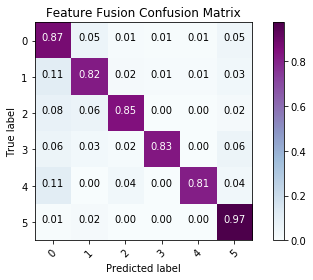

In [157]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, normalize = False, title='Feature Fusion Confusion Matrix', cmap = 'BuPu'):
    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('feature_fusion_matrix', format='eps', dpi=4000)


# Compute confusion matrix
plt.close()
plot_confusion_matrix(cm, classes = range(6), normalize = True)

In [160]:
with open('gt_list.pkl', 'wb') as handle:
    pickle.dump(gt_list, handle)
    
with open('preds_list.pkl', 'wb') as handle:
    pickle.dump(preds_list, handle)

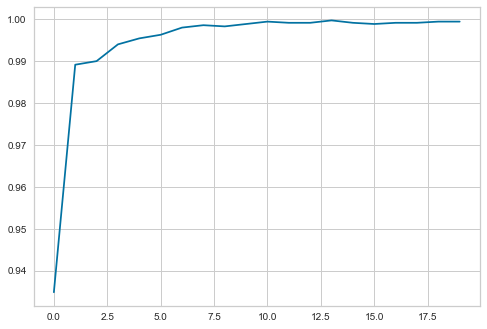

In [190]:
plt.plot(train_acc_history)

In [166]:
import pandas as pd
import os
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [184]:
x_total = list(train_data.numpy()) + list(test_data.numpy()) + list(val_data.numpy())
label_total = list(train_labels.numpy()) + list(test_labels.numpy()) + list(val_labels.numpy())

In [185]:
labels= ['damaged_infrastucture', 'damaged_nature', 'fires', 'flood', 'human_damage', 'non_damage']
label_strings = [labels[val] for val in label_total]

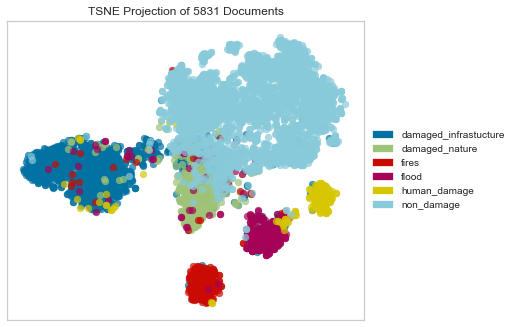

In [189]:
tsne = TSNEVisualizer()
tsne.fit(np.array(x_total), np.array(label_strings))
tsne.poof()